In [2]:
from definitions import *
from plots import *

In [51]:
da_s = xr.open_dataarray('../data/s_anom.nc').sel(time=DATERANGEPL_SUMMER)
da_T = xr.open_dataarray('../data/t_anom.nc').sel(time=DATERANGEPL_SUMMER)
lon = da_s.lon.values
lat = da_s.lat.values
X = da_s.values

In [52]:
alljets = find_all_jets(da_s, X, processes=16)

In [62]:
isdouble = da_s[:, 0, 0].copy(data=np.zeros(len(da_s), dtype=bool)).reset_coords(['lon', 'lat'], drop=True).rename('isdouble')
issingle = isdouble.copy().rename('issingle')
da_props = xr.DataArray(np.zeros((len(da_s), 4)), coords={'time': da_s.time.values, 'var': ['x', 'y', 'tilt', 'accel']})

jet_props = [] 
for i, jets in enumerate(alljets):
    jet_props.append([])
    for jet in jets:
        x, y, s = jet.T
        meanlon = np.average(x, weights=s)
        meanlat = np.average(y, weights=s)
        meantilt = np.nanmean(np.gradient(y, x))
        meanacc = np.nanmean(np.gradient(s, x))
        overeurope = np.trapz(s[x > -10], x[x > -10]) > 1500
        
        jet_props[-1].append([
            meanlon, meanlat, meantilt, meanacc, overeurope
        ])
    tbavged = []
    meany = -1000
    for props in jet_props[-1]:
        if props[-1] and (np.abs(props[1] - meany) > 15): 
            meany = props[1]
            tbavged.append(props[:4])
    isdouble[i] = len(tbavged) > 1
    issingle[i] = len(tbavged) == 1
    da_props[i] = np.nanmean(tbavged, axis=0)

/var/folders/zb/qrvsjg590771qgw5yhnx1vmw0000gn/T/ipykernel_12023/3292637141.py:27: RuntimeWarning: Mean of empty slice
  da_props[i] = np.nanmean(tbavged, axis=0)
/Users/bandelol/mambaforge/envs/env/lib/python3.11/site-packages/numpy/lib/function_base.py:1240: RuntimeWarning: divide by zero encountered in divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/Users/bandelol/mambaforge/envs/env/lib/python3.11/site-packages/numpy/lib/function_base.py:1241: RuntimeWarning: divide by zero encountered in divide
  b = (dx2 - dx1) / (dx1 * dx2)
/Users/bandelol/mambaforge/envs/env/lib/python3.11/site-packages/numpy/lib/function_base.py:1242: RuntimeWarning: divide by zero encountered in divide
  c = dx1 / (dx2 * (dx1 + dx2))
/Users/bandelol/mambaforge/envs/env/lib/python3.11/site-packages/numpy/lib/function_base.py:1248: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/Users/bandelol/mambaforge/envs/env/lib/python3.11

In [63]:
np.mean(isdouble)

<xarray.DataArray 'isdouble' ()>
array(0.14803313)

In [113]:
mask1 = np.stack([issingle.values, isdouble.values], axis=1)
mask1labs = ['single', 'double']
x, y, tilt, acc = da_props.values.T
bins = [-10, 0, 10, 20, 30, 60]
mask2 = np.stack([(x >= bins[i]) & (x < bins[i + 1]) for i in range(len(bins) - 1)], axis=1)
mask2labs = [f'${bins[i]} \leq \lambda<{bins[i + 1]}$' for i in range(len(bins) - 1)]

mask = (mask1[:, :, None] & mask2[:, None, :]).reshape(len(mask1), -1)
masklabs = np.asarray([f'{lab1}, {lab2}' for lab1 in mask1labs for lab2 in mask2labs])

/Users/bandelol/mambaforge/envs/env/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


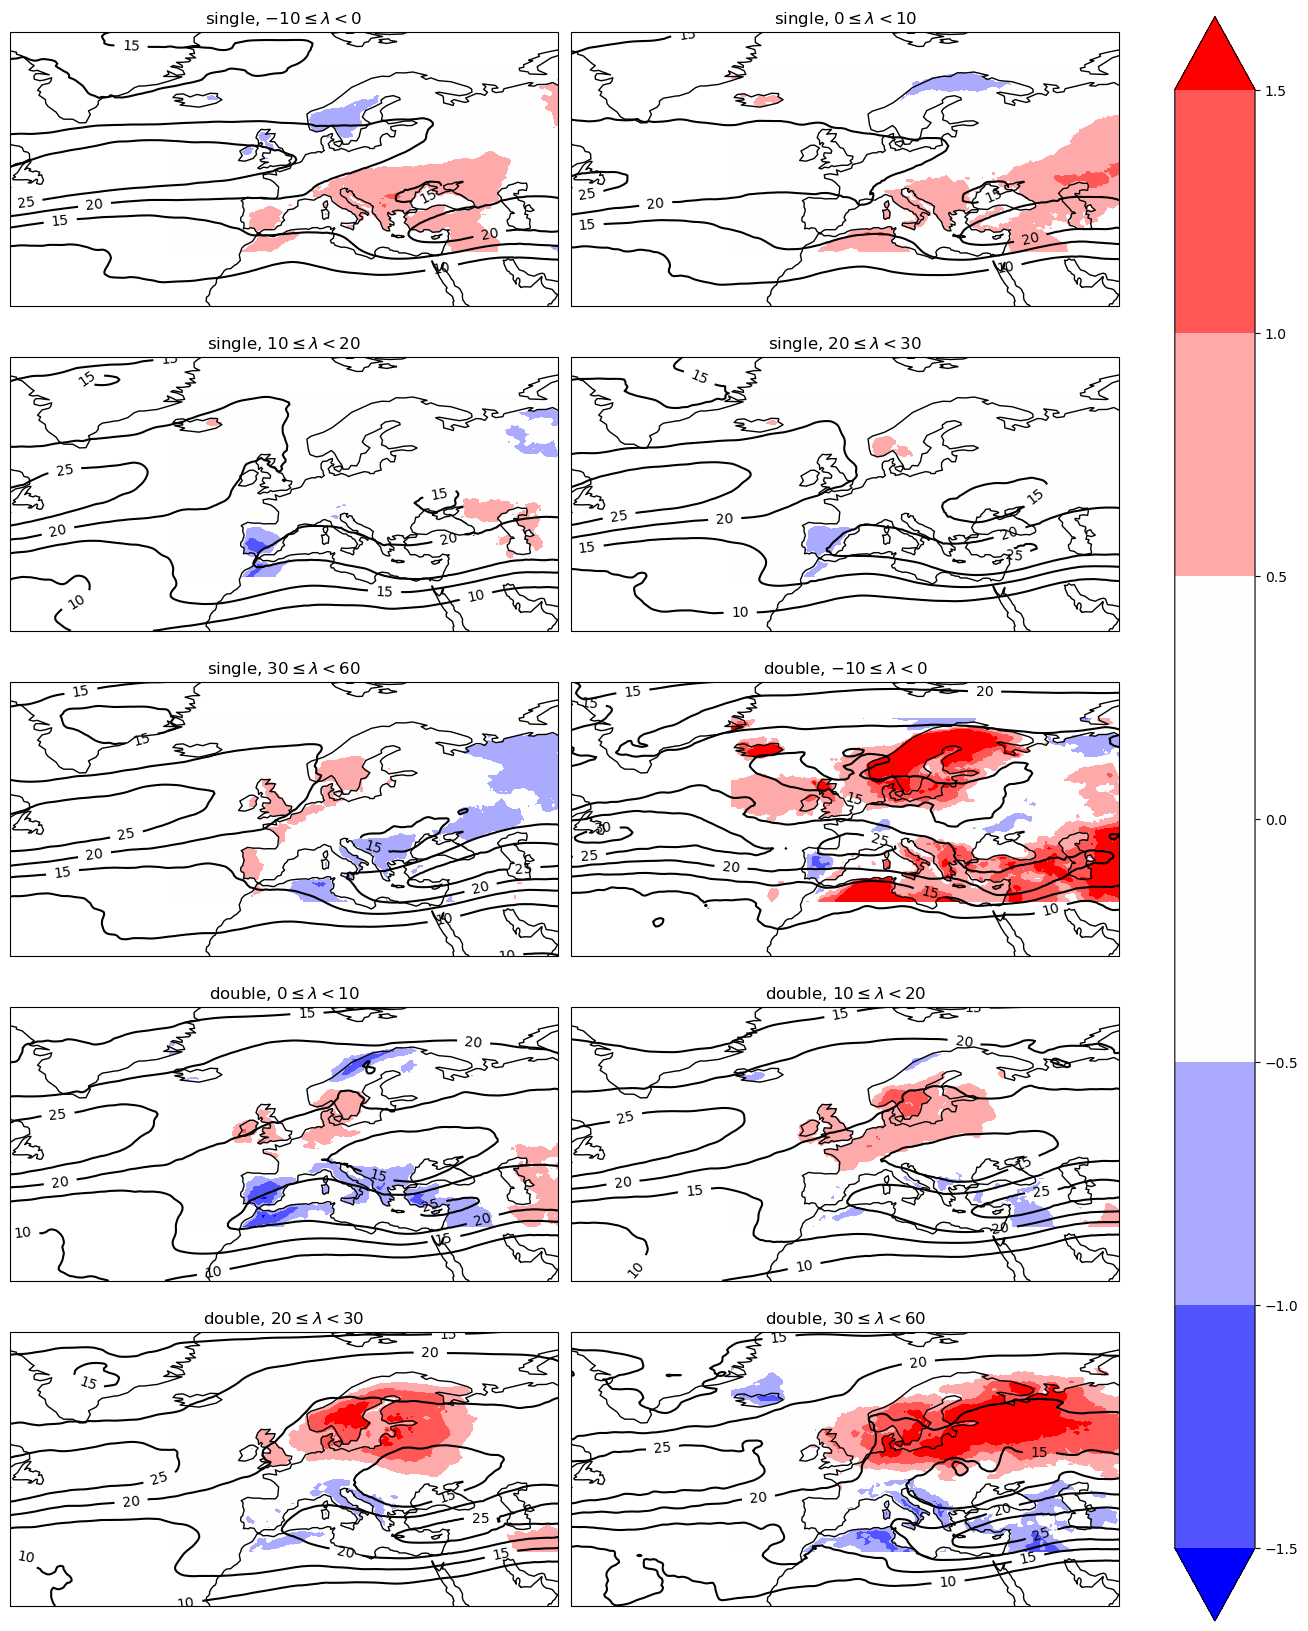

In [115]:
clu = Clusterplot(5, 2, region=(-60, 60, 20, 80))
clu.add_any_contour_from_mask(da_s, mask, type='contour', clabels=True)
clu.add_any_contour_from_mask(da_T, mask, type='contourf', titles=masklabs)

/Users/bandelol/mambaforge/envs/env/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


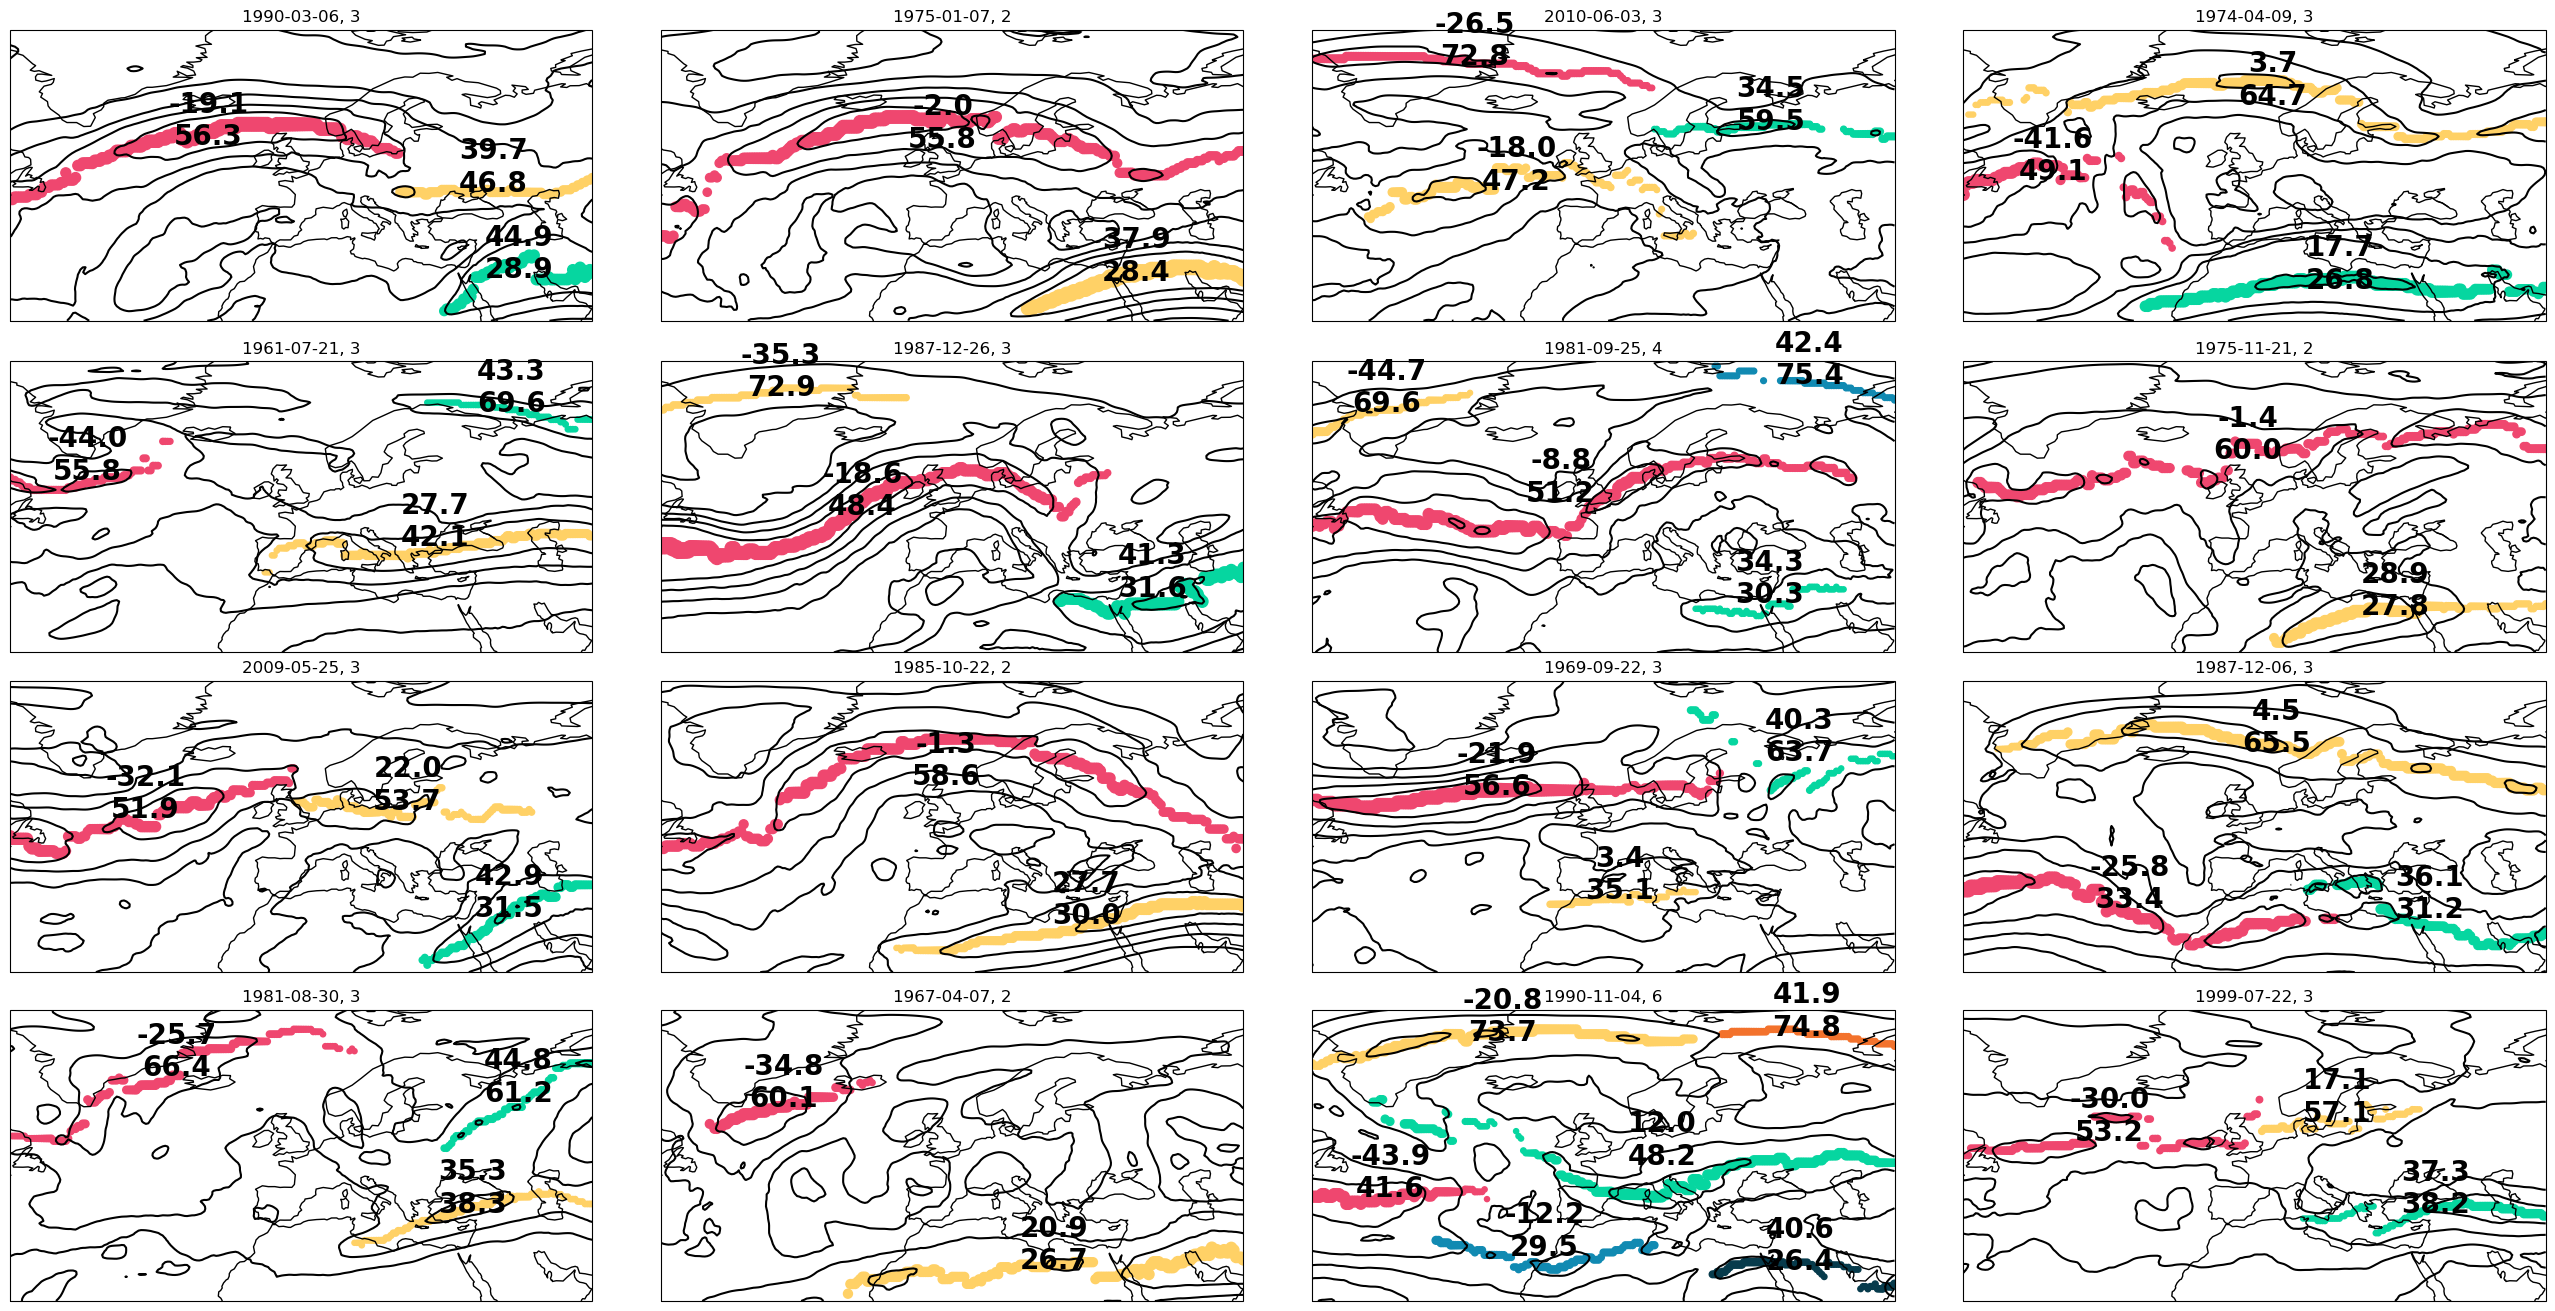

In [24]:
clu = Clusterplot(4, 4, region=(-60, 60, 20, 80))
tsteps = np.random.randint(len(da_s), size=clu.ncol * clu.nrow)
clu.add_contour([da_s[t] for t in tsteps])
for i, t in enumerate(tsteps):
    time = np.datetime_as_string(da_T[t].time.values, unit='D')
    x = da_s[t].values
    jets = alljets[t]
    for j, jet in enumerate(jets):
        x, y, s = jet.T
        c = COLORS5[j % 6]
        clu.axes[i].scatter(x, y, marker='o', color=c, linewidths=1, s=s ** 2 / 30)
        ds_props = jet_props[t][j]
        clu.axes[i].text(
            ds_props[0], ds_props[1], '\n'.join([f'{val:.1f}' for val in ds_props[:2]]), 
            fontsize=20, ha='center', fontweight='bold'
        )
    clu.axes[i].set_title(f'{time}, {len(jets)}')

In [11]:
' '.join([f'{val:.2f}' for val in jet_props[23][0]])

'-45.02 42.38 -0.07 nan'

In [ ]:
plt.text()